# Fourth Script:
1. Prepare (balance etc.) dataset for classification
2. Run few Classification models on existing embeddings of reviews (binary label)
3. Print some plots to show the results

In [1]:
!pip install pandas gensim matplotlib
!pip install pytz
!pip install transformers
!pip install matplotlib reportlab
!pip install reportlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.9 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('words')
import pandas as pd
import numpy as np
import random
from nltk.corpus import words
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
import os
import re
from IPython.display import display


#import embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')
# drive.mount('/content/drive')
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FCU6Y-6uab9X06OsqU9QRcerr_S7Mbez' -O settings.txt
import seaborn as sns
import matplotlib.pyplot as plt

# Datetime
from datetime import datetime
import time
import pytz

# Threading package
import concurrent.futures
import multiprocessing
import pickle

# Statistics package
from scipy.stats import ttest_ind

# PDF extrating packages
from reportlab.lib.pagesizes import letter, A4, landscape
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
from reportlab.lib import colors
from reportlab.lib.units import inch


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Mounted at /gdrive


# Includes Ttest and deep learning

In [25]:
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def confidence_interval(accuracy, n, z=1.96):
    """
    Compute the confidence interval for a given accuracy.
    Parameters:
    - accuracy (float): Observed accuracy.
    - n (int): Sample size.
    - z (float, optional): Z-score, default is 1.96 for a 95% confidence interval.
    Returns:
    - tuple: Lower and upper bounds of the confidence interval.
    """
    delta = z * np.sqrt((accuracy * (1 - accuracy)) / n)
    return accuracy - delta, accuracy + delta

def plot_roc_curve(y_true, y_probs, model_name, pdf_path='/gdrive/My Drive/Amazon/results/Full_Dataset/pdfs'):
    """
    Plot ROC curve for the model and display AUC in the legend.
    Parameters:
    - pdf_path (str): Path to the pdf folder.
    - y_true (array-like): True binary labels.
    - y_probs (array-like): Target scores, can either be probability estimates of the positive class or confidence values.
    - model_name (str): Name of the model for display in the legend.

    returns a path to png file of the roc curve
    """
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_true, y_probs):.4f})")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Main diagonal
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='best')
    plt.grid()

    # Save the plot before showing it
    roc_cureve_plot_filename = os.path.join(pdf_path, model_name+"_roc_curve.png")
    plt.savefig(roc_cureve_plot_filename)

    # Display the plot
    plt.show()
    plt.close()

    return roc_cureve_plot_filename

def plot_confusion_matrix(y_true, y_pred, model_name, pdf_path='/gdrive/My Drive/Amazon/results/Full_Dataset/pdfs'):
    """
    Plot the confusion matrix for the given model.
    Parameters:
    - pdf_path (str): Path to the pdf folder.
    - y_true (array-like): True binary labels.
    - y_pred (array-like): Predicted binary labels.
    - model_name (str): Name of the model.

    returns a path to png file of the confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot before showing it
    confusion_matrix_plot_filename = os.path.join(pdf_path, model_name+"_confusion_matrix.png")
    plt.savefig(confusion_matrix_plot_filename)

    # Display the plot
    plt.show()
    plt.close()

    return confusion_matrix_plot_filename


def plot_bar_with_confidence_interval_seaborn(mean_value, ci_lower, ci_upper, title='Bar Plot with Confidence Interval', ylabel='Value', bar_label='Data'):
    """
    Plot a bar chart with confidence intervals using Seaborn.

    Parameters:
    - mean_value (float): The mean value to be plotted as a bar.
    - ci_lower (float): The lower bound of the confidence interval.
    - ci_upper (float): The upper bound of the confidence interval.
    - title (str, optional): Title of the plot.
    - ylabel (str, optional): Label for the Y-axis.
    - bar_label (str, optional): Label for the bar.
    """

    # Create a DataFrame for the plot
    data = pd.DataFrame({'Label': [bar_label], 'Mean': [mean_value], 'CI Lower': [ci_lower], 'CI Upper': [ci_upper]})

    # Initialize the matplotlib figure
    plt.figure(figsize=(6, 4))

    # Create the bar plot
    sns.barplot(x='Label', y='Mean', data=data, color='skyblue')

    # Add error lines for CI
    plt.errorbar(x=bar_label, y=mean_value, yerr=[[mean_value - ci_lower], [ci_upper - mean_value]], fmt='none', capsize=5, color='black')

    # Set plot titles and labels
    plt.title(title)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()




def evaluate_models(df_path, label_col="label", vector_col="doc2vec_embedding", additional_features=[], selected_models=[], to_balance=False, to_shuffle_label=False, plot_height = 280):
    """
    Evaluate selected machine learning models based on the provided dataframe.

    Parameters:
    - df_path (str): Path to the dataset in CSV format.
    - label_col (str): Name of the column containing target labels.
    - vector_col (str): Name of the column containing embedded vectors.
    - additional_features (list): List of columns' names for additional features to include in the model training.
    - selected_models (list): List of models' names to evaluate.
    - to_balance (bool): Whether to balance the dataset if it's imbalanced.
    - to_shuffle_label (bool): Shuffle the label column - to check how the models work for random labeling.
    - plot_height (int): Height of the plot for the pdf
    """
    # Load the dataset and convert embedded vectors from string to numpy arrays
    df = pd.read_csv(os.path.join('/gdrive/My Drive/Amazon/results/', df_path), converters={vector_col: lambda x: np.fromstring(x.strip("[]"), sep=" ")})


    # Shuffle the 'label' column while keeping the original index
    if to_shuffle_label:
      print(f"Labels are shuffled - check how the models predict random labeling!")
      output_name = 'shuffled_labeles_results_'+datetime.now().strftime("%d.%m.%Y_%H:%M")
      df['label'] = df['label'].sample(frac=1).values
    # create a name for the output pdf file
    else :
      output_name = 'results_'+datetime.now().strftime("%d.%m.%Y_%H:%M")

    # Start creating a PDF
    pdf_filename = os.path.join('/gdrive/My Drive/Amazon/results/Full_Dataset/pdfs', output_name+".pdf")
    c = canvas.Canvas(pdf_filename, pagesize=landscape(A4))
    width, height = landscape(A4)
    y_position = height - 72  # Initial Y position


    # Add header text
    c.setFont("Helvetica-Bold", 14)  # Set font and size for the header
    c.drawString(1 * inch, y_position, output_name)
    y_position -= 40  # Adjust position after header

    # Add additional text
    c.setFont("Helvetica", 12)  # Set font and size for the additional text
    c.drawString(1 * inch, y_position, 'models: '.join(selected_models))
    y_position -= 40  # Adjust position after header

    def add_new_page():
      c.showPage()  # Finish the current page and start a new one
      c.setFont("Helvetica-Bold", 14)
      # c.drawString(72, height - 72, header_text)  # Add header to each new page
      return height - 112  # Adjust initial y_position for new page


    # Check if the dataset is balanced
    label_counts = df[label_col].value_counts()
    print(f"Label Distribution:\n{label_counts}")
    # Add the texts to the pdf
    c.drawString(72, y_position, f"Label Distribution:\n{label_counts}")
    y_position -= 40
    is_balanced = label_counts.min() == label_counts.max()
    print(f"Data is {'balanced' if is_balanced else 'not balanced'}.")

    # Print the difference in label counts if data is unbalanced
    if not is_balanced:
        label_diff = label_counts[0] - label_counts[1]
        print(f"Difference between label counts: {abs(label_diff)}")

    # Balance the dataset if needed and requested
    if not is_balanced and to_balance:
        min_label_count = label_counts.min()
        df_balanced = pd.concat([df[df[label_col] == 0].sample(min_label_count), df[df[label_col] == 1].sample(min_label_count)])
    else:
        df_balanced = df

    # Extract features and labels
    X = np.stack(df_balanced[vector_col].to_numpy())
    if additional_features:
        additional_data = df_balanced[additional_features].to_numpy()
        X = np.hstack((X, additional_data))
    y = df_balanced[label_col].values

    # Print vector size and number of samples
    print(f"Vector Size: {X.shape[1]}")
    print(f"Total Number of Samples: {X.shape[0]}")
    # Add the texts to the pdf
    c.drawString(72, y_position, f"Vector Size: {X.shape[1]}")
    y_position -= 40
    c.drawString(72, y_position, f"Total Number of Samples: {X.shape[0]}")
    y_position -= 40

    # Splitting dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Print the proportion of labels in the training dataset
    print("\nTraining dataset:")
    print("Proportion of label 0:", np.mean(y_train == 0))
    print("Proportion of label 1:", np.mean(y_train == 1))

    # Print the proportion of labels in the testing dataset
    print("\nTesting dataset:")
    print("Proportion of label 0:", np.mean(y_test == 0))
    print("Proportion of label 1:", np.mean(y_test == 1))

    print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")
    # Add the texts to the pdf
    c.drawString(72, y_position, f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")
    y_position -= 300

    # Define Neural Network models with their architectures
    nn_models = {
        "Neural Network with Dropout": Sequential([
            Dense(128, activation='relu', input_dim=X_train.shape[1]),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ]),
        "Dense Neural Network": Sequential([
            Dense(256, activation='relu', input_dim=X_train.shape[1]),
            Dense(128, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    }

    # Define traditional ML models
    ml_models = {
        "Logistic Regression": LogisticRegression(max_iter=10000),
        "SVM": SVC(probability=True, kernel='linear'),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier()
    }

    # Combine both dictionaries of models
    models = {**nn_models, **ml_models}

    for model_name, model in models.items():
        # Check if the model is selected for evaluation
        if model_name not in selected_models:
            continue

        # Train Neural Network models and generate predictions
        if model_name in nn_models:
            model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
            y_pred_probs = model.predict(X_test).ravel()
        # Train traditional ML models and generate predictions
        else:
            model.fit(X_train, y_train)
            y_pred_probs = model.predict_proba(X_test)[:, 1]

        # Convert predicted probabilities to binary class predictions
        y_pred = (y_pred_probs > 0.5).astype('int32')

        # Check if we need a new page to the pdf
        if y_position < 200:  # Adjust the threshold as needed
            y_position = add_new_page() - 188

        # Visualize evaluation metrics

        roc_curve_filename=plot_roc_curve(y_test, y_pred_probs, model_name)
        # Add roc curve the to PDF
        roc_curve_image = ImageReader(roc_curve_filename)
        c.drawImage(roc_curve_image, 72, y_position, width=432, height=plot_height, preserveAspectRatio=True, mask='auto')
        y_position -= 290  # Adjust position for next content

        confusion_matrix_filename=plot_confusion_matrix(y_test, y_pred, model_name)
        # Add roc curve the to PDF
        confusion_matrix_image = ImageReader(confusion_matrix_filename)
        c.drawImage(confusion_matrix_image, 72, y_position, width=432, height=plot_height, preserveAspectRatio=True, mask='auto')
        y_position -= 40  # Adjust position for next content



        # Check if we need a new page to the pdf
        if y_position < 200:  # Adjust the threshold as needed
            y_position = add_new_page()

        # Calculate and display evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        print(f"Accuracy for {model_name}: {accuracy*100:.2f}%")
        print(f"Precision for {model_name}: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f_score:.4f}")
        # Add the texts to the pdf
        c.drawString(72, y_position, f"Accuracy for {model_name}: {accuracy*100:.2f}%")
        y_position -= 20
        c.drawString(72, y_position, f"Precision for {model_name}: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f_score:.4f}")
        y_position -= 20

        # Perform t-test to check if the mean of predicted probabilities differs from the mean of true labels
        # t_stat, p_value = stats.ttest_1samp(y_pred_probs, y_test.mean()) # oldversion for y_pred_probs
        # t_stat, p_value = stats.ttest_1samp(y_pred, y_test.mean()) # calculate ttest for the prediction
        # ttest for the true_predictions compared to 0.5 - only valid for totaly balanced data. check the propability that the data is rabdom (mean - 0.5 when the data is balanced)
        true_predictions = (y_pred == y_test).astype(int)
        res = stats.ttest_1samp(a=true_predictions, popmean=0.5)
        # t_stat, p_value = stats.ttest_1samp(a=true_predictions, popmean=0.5)
        t_stat, p_value = res.statistic, res.pvalue
        print(f"t-test for {model_name} prediction vs 0.5:")
        print(f"t-statistic: {t_stat}, p-value: {p_value}")

        # Add the texts to the pdf
        c.drawString(72, y_position, f"t-test for {model_name} prediction vs 0.5:")
        y_position -= 20
        c.drawString(72, y_position, f"t-statistic: {t_stat}, p-value: {p_value}")
        y_position -= 20


        # Calculate and display the 95% Confidence Interval for accuracy
        # ci_lower, ci_upper = confidence_interval(accuracy, len(y_test))
        ci = res.confidence_interval(confidence_level=0.95)
        ci_lower, ci_upper= ci.low, ci.high
        print(f"95% Confidence Interval for {model_name} Accuracy: [{ci_lower:.4f}, {ci_upper:.4f}]")

        # Add the texts to the pdf
        c.drawString(72, y_position, f"95% Confidence Interval for {model_name} Accuracy: [{ci_lower:.4f}, {ci_upper:.4f}]")
        y_position -= 20

        # T-test interpretation
        if p_value < 0.05:
            print(f"The results for {model_name} are statistically significant with a p-value of {p_value:.10f}.")
            c.drawString(72, y_position, f"The results for {model_name} are statistically significant with a p-value of {p_value:.4f}.")
            y_position -= 20
        else:
            print(f"The results for {model_name} are not statistically significant with a p-value of {p_value:.10f}.")
            c.drawString(72, y_position, f"The results for {model_name} are not statistically significant with a p-value of {p_value:.4f}.")
            y_position -= 20


        plot_bar_with_confidence_interval_seaborn(mean_value=accuracy, ci_lower=ci_lower, ci_upper=ci_upper, title='Bar Plot with ci', ylabel='Accuracy', bar_label=model_name)

        # irrelavent - compared to y_test.mean and not to 0.5
        # # Confidence Interval interpretation
        # if y_test.mean() >= ci_lower and y_test.mean() <= ci_upper:
        #     print(f"The true accuracy for {model_name} is likely within the 95% confidence interval [{ci_lower:.4f}, {ci_upper:.4f}].")
        #     c.drawString(72, y_position, f"The true accuracy for {model_name} is likely within the 95% confidence interval [{ci_lower:.4f}, {ci_upper:.4f}].")
        #     y_position -= 20
        # else:
        #     print(f"The true accuracy for {model_name} might not be within the 95% confidence interval [{ci_lower:.4f}, {ci_upper:.4f}].")
        #     c.drawString(72, y_position, f"The true accuracy for {model_name} might not be within the 95% confidence interval [{ci_lower:.4f}, {ci_upper:.4f}].")
        #     y_position -= 20

    c.save()






# Run evaluate_models after balancing

Label Distribution:
0    11603
1    11603
Name: label, dtype: int64
Data is balanced.
Vector Size: 50
Total Number of Samples: 23206

Training dataset:
Proportion of label 0: 0.5
Proportion of label 1: 0.5

Testing dataset:
Proportion of label 0: 0.5
Proportion of label 1: 0.5
Training Samples: 18564, Testing Samples: 4642
Epoch 1/10
581/581 [==============================] - 4s 5ms/step - loss: 0.6935 - accuracy: 0.5114 - val_loss: 0.6904 - val_accuracy: 0.5317
Epoch 2/10
581/581 [==============================] - 2s 4ms/step - loss: 0.6898 - accuracy: 0.5282 - val_loss: 0.6857 - val_accuracy: 0.5584
Epoch 3/10
581/581 [==============================] - 2s 3ms/step - loss: 0.6822 - accuracy: 0.5521 - val_loss: 0.6791 - val_accuracy: 0.5666
Epoch 4/10
581/581 [==============================] - 2s 3ms/step - loss: 0.6762 - accuracy: 0.5651 - val_loss: 0.6745 - val_accuracy: 0.5694
Epoch 5/10
581/581 [==============================] - 2s 3ms/step - loss: 0.6713 - accuracy: 0.5780 - val_l

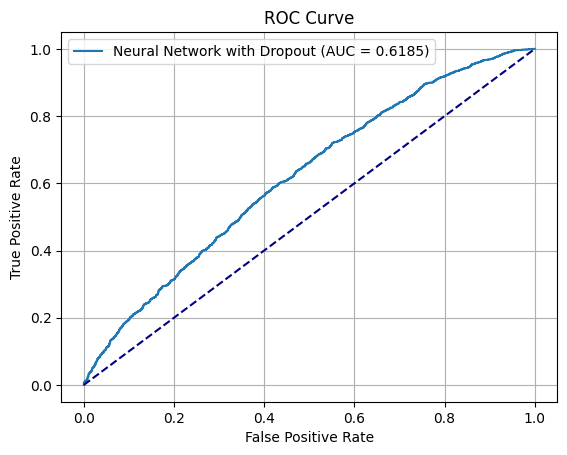

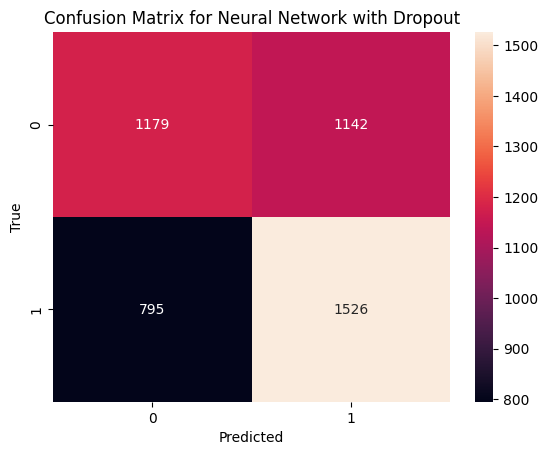

Accuracy for Neural Network with Dropout: 58.27%
Precision for Neural Network with Dropout: 0.5720, Recall: 0.6575, F1-Score: 0.6117
t-test for Neural Network with Dropout prediction vs 0.5:
t-statistic: 11.42848239172921, p-value: 7.530072540487873e-30
95% Confidence Interval for Neural Network with Dropout Accuracy: [0.5685, 0.5969]
The results for Neural Network with Dropout are statistically significant with a p-value of 0.0000000000.


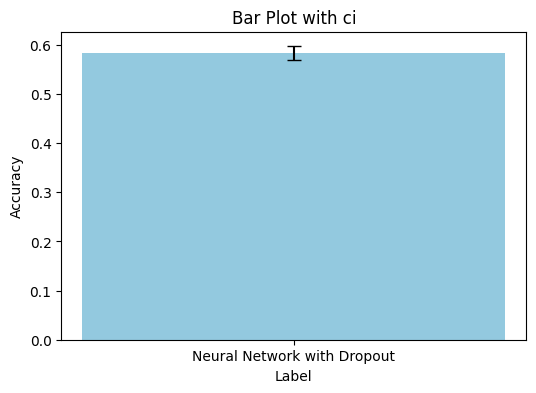

Epoch 1/10
581/581 [==============================] - 3s 4ms/step - loss: 0.6867 - accuracy: 0.5371 - val_loss: 0.6766 - val_accuracy: 0.5642
Epoch 2/10
581/581 [==============================] - 3s 5ms/step - loss: 0.6667 - accuracy: 0.5816 - val_loss: 0.6735 - val_accuracy: 0.5760
Epoch 3/10
581/581 [==============================] - 5s 9ms/step - loss: 0.6509 - accuracy: 0.6053 - val_loss: 0.6678 - val_accuracy: 0.5737
Epoch 4/10
581/581 [==============================] - 3s 4ms/step - loss: 0.6344 - accuracy: 0.6278 - val_loss: 0.6725 - val_accuracy: 0.5864
Epoch 5/10
581/581 [==============================] - 2s 3ms/step - loss: 0.6169 - accuracy: 0.6509 - val_loss: 0.6856 - val_accuracy: 0.5844
Epoch 6/10
581/581 [==============================] - 2s 4ms/step - loss: 0.5971 - accuracy: 0.6752 - val_loss: 0.6816 - val_accuracy: 0.5821
Epoch 7/10
581/581 [==============================] - 3s 5ms/step - loss: 0.5744 - accuracy: 0.6924 - val_loss: 0.6958 - val_accuracy: 0.5842
Epoch 

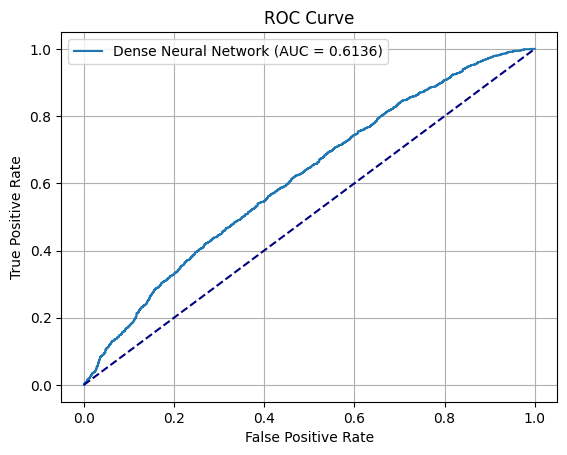

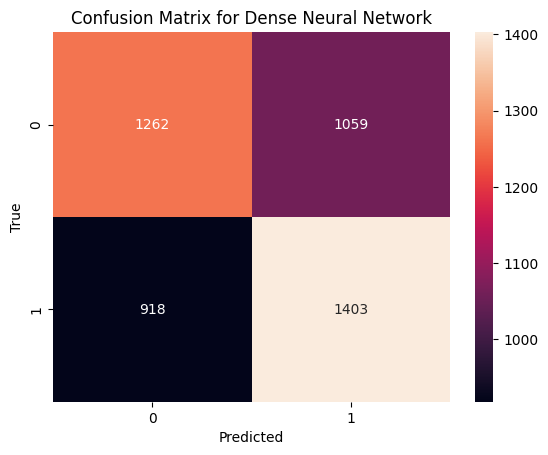

Accuracy for Dense Neural Network: 57.41%
Precision for Dense Neural Network: 0.5699, Recall: 0.6045, F1-Score: 0.5867
t-test for Dense Neural Network prediction vs 0.5:
t-statistic: 10.209683647358192, p-value: 3.2299161660386046e-24
95% Confidence Interval for Dense Neural Network Accuracy: [0.5599, 0.5883]
The results for Dense Neural Network are statistically significant with a p-value of 0.0000000000.


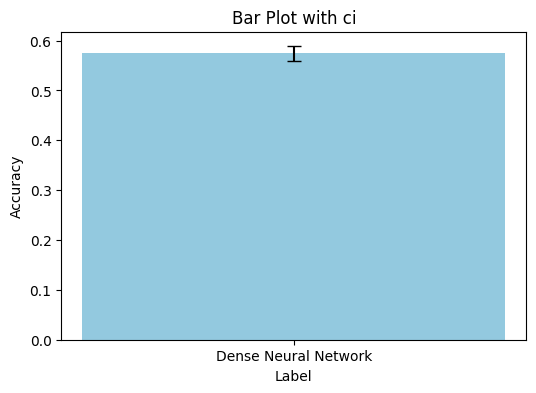

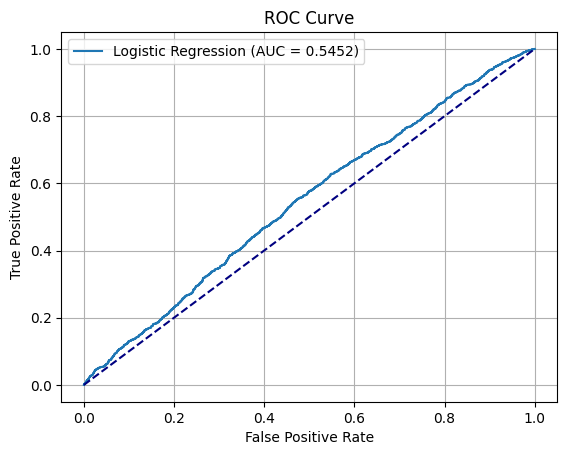

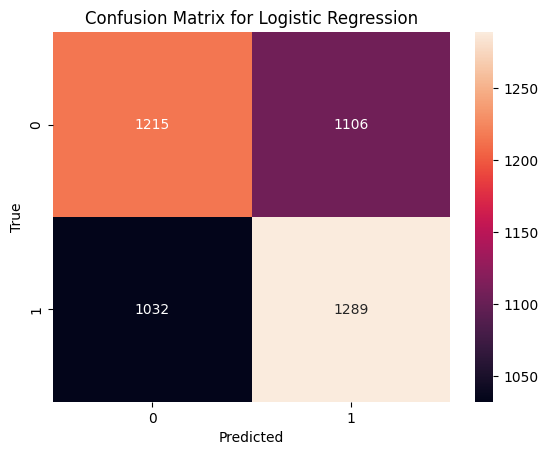

Accuracy for Logistic Regression: 53.94%
Precision for Logistic Regression: 0.5382, Recall: 0.5554, F1-Score: 0.5466
t-test for Logistic Regression prediction vs 0.5:
t-statistic: 5.3881026532153085, p-value: 7.472819688188797e-08
95% Confidence Interval for Logistic Regression Accuracy: [0.5251, 0.5538]
The results for Logistic Regression are statistically significant with a p-value of 0.0000000747.


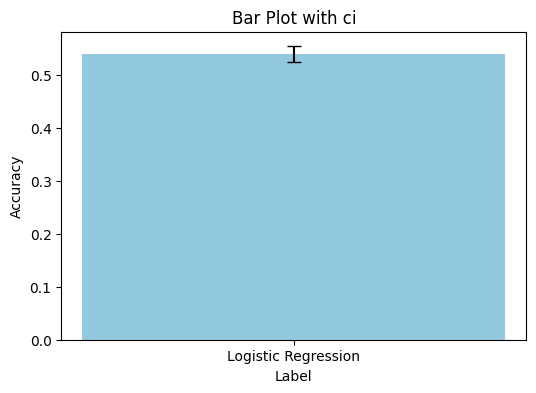

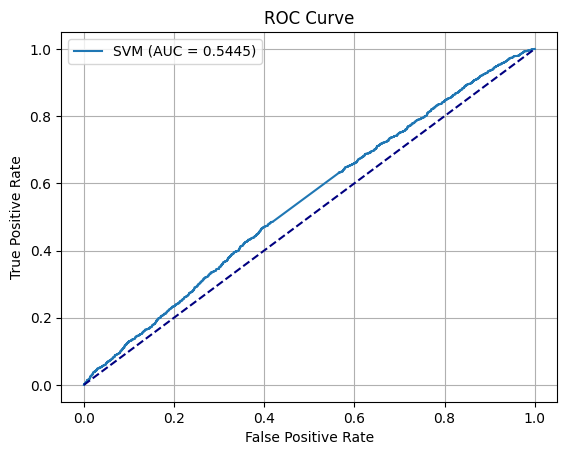

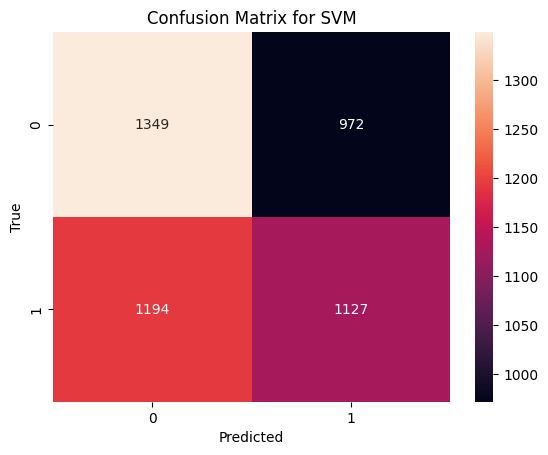

Accuracy for SVM: 53.34%
Precision for SVM: 0.5369, Recall: 0.4856, F1-Score: 0.5100
t-test for SVM prediction vs 0.5:
t-statistic: 4.559664999734574, p-value: 5.2553912892613924e-06
95% Confidence Interval for SVM Accuracy: [0.5190, 0.5477]
The results for SVM are statistically significant with a p-value of 0.0000052554.


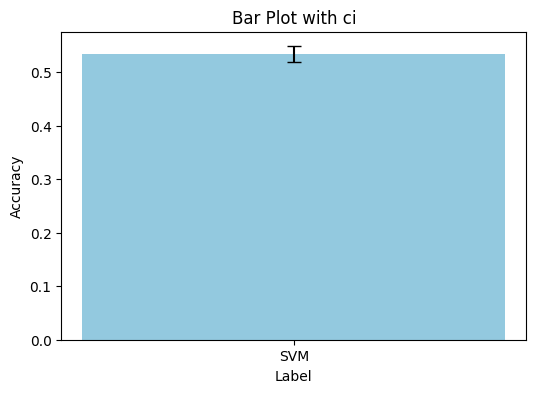

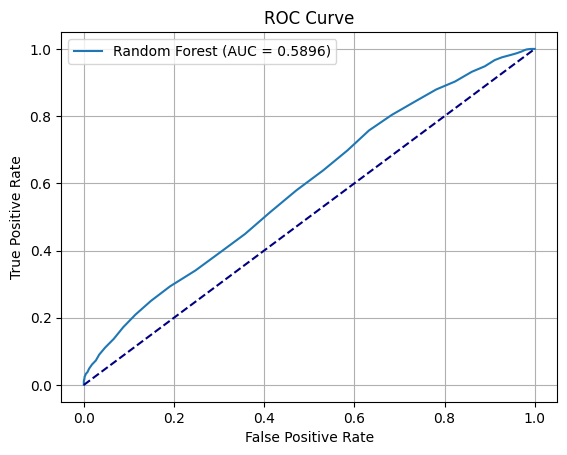

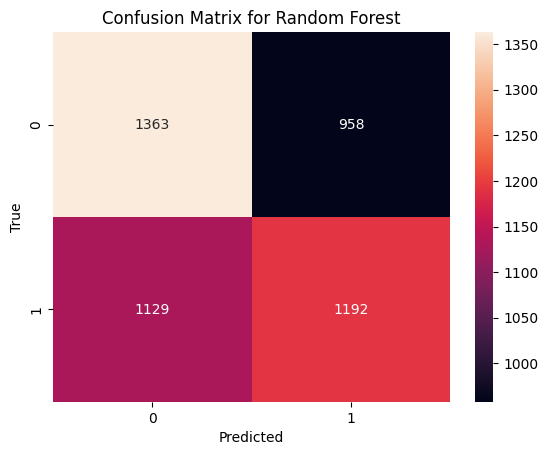

Accuracy for Random Forest: 55.04%
Precision for Random Forest: 0.5544, Recall: 0.5136, F1-Score: 0.5332
t-test for Random Forest prediction vs 0.5:
t-statistic: 6.903430625328543, p-value: 5.76110148771952e-12
95% Confidence Interval for Random Forest Accuracy: [0.5361, 0.5647]
The results for Random Forest are statistically significant with a p-value of 0.0000000000.


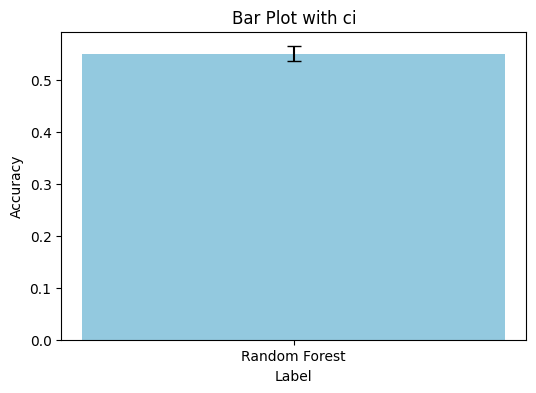

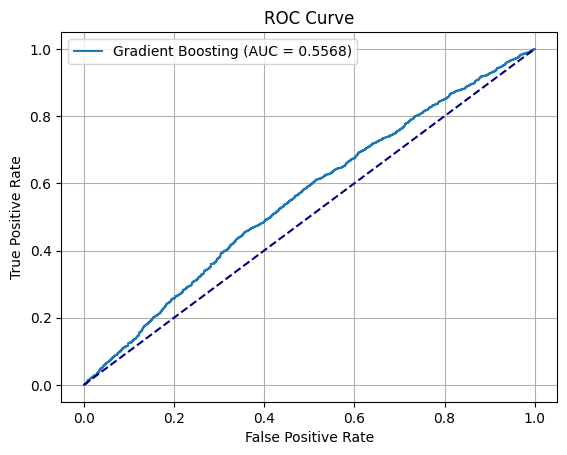

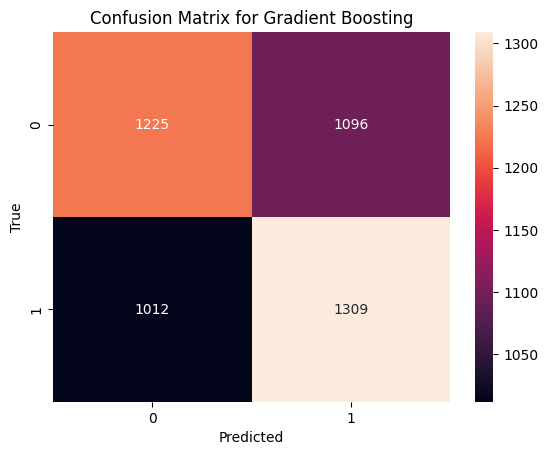

Accuracy for Gradient Boosting: 54.59%
Precision for Gradient Boosting: 0.5443, Recall: 0.5640, F1-Score: 0.5540
t-test for Gradient Boosting prediction vs 0.5:
t-statistic: 6.278368163004889, p-value: 3.733983257102946e-10
95% Confidence Interval for Gradient Boosting Accuracy: [0.5316, 0.5602]
The results for Gradient Boosting are statistically significant with a p-value of 0.0000000004.


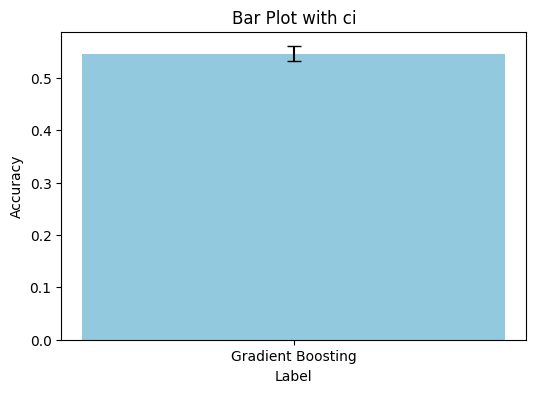

In [26]:
evaluate_models(df_path='Full_Dataset/removed_unmatched_full_balanced_labeled_dataset_doc2vec_embedded.csv', selected_models = ['Neural Network with Dropout', 'Dense Neural Network', "Logistic Regression","SVM","Random Forest", "Gradient Boosting"], to_balance=False)

Run the models for shuffled labels

In [ ]:
evaluate_models(df_path='Full_Dataset/removed_unmatched_full_balanced_labeled_dataset_doc2vec_embedded.csv', selected_models = ['Neural Network with Dropout', 'Dense Neural Network', "Logistic Regression","SVM","Random Forest", "Gradient Boosting"], to_balance=False, to_shuffle_label=True)

# Remove the 'unbalanced' rows (label 1)

In [ ]:
def display_file_content(base_path, folder_name, file_name='balanced_labeled_dataset.csv'):
    """
    Display the content of a file within a specified folder.

    Parameters:
    - base_path (str): The base path to the directory.
    - folder_name (str): The name of the folder containing the file.
    - file_name (str): The name of the file to be displayed.
    """
    # Construct the full file path
    full_path = f"{base_path}{folder_name}/{file_name}"

    # Load and display the file content
    try:
        df = pd.read_csv(full_path)
        print(df)
    except FileNotFoundError:
        print(f"File not found: {full_path}")

# Define the base path and folder name
base_path = '/gdrive/My Drive/Amazon/results/'
folder_name = 'Office_Products_5'

# Display the file content
# display_file_content(base_path, folder_name)

Find the rows that arent balanced

In [ ]:
def save_unmatched_label_1_rows(base_path, folder_names):
    """
    Save and display a new dataset with unmatched label 1 rows for each category,
    and print the count of unmatched rows per category.

    Parameters:
    - base_path (str): The base path to the directory.
    - folder_names (list): A list of category names to be processed.

    Returns:
    - unmatched_data (DataFrame): A DataFrame containing unmatched rows.
    """
    unmatched_rows = []

    for category in folder_names:
        file_path = f"{base_path}{category}/balanced_labeled_dataset.csv"
        try:
            # Load the dataset
            df = pd.read_csv(file_path)

            # Separate label 1 and label 0 rows
            label_1_rows = df[df['label'] == 1]
            label_0_rows = df[df['label'] == 0]

            # Find unmatched label 1 rows
            for index, row_1 in label_1_rows.iterrows():
                if row_1['index'] not in label_0_rows['left_matching'].values:
                    unmatched_rows.append((category, index, row_1['index']))

        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"An error occurred: {e}")

    # Create DataFrame with MultiIndex
    unmatched_data = pd.DataFrame(unmatched_rows, columns=['category', 'Original Index', 'Unmatched category index'])
    unmatched_data.set_index(['category', 'Original Index'], inplace=True)

    # Count unmatched rows per category
    count_per_category = unmatched_data.index.get_level_values('category').value_counts()
    print("Count of unmatched label 1 rows per category:")
    print(count_per_category)

    return unmatched_data

# # Define the base path
# base_path = '/gdrive/My Drive/Amazon/results/'

# # Example usage
# folder_names =  ['Office_Products','Arts_Crafts_and_Sewing', 'Electronics', 'Home_and_Kitchen', 'Tools_and_Home_Improvement']    # Replace with your actual folder names
# unmatched_data = save_unmatched_label_1_rows(base_path, folder_names)

# # You can then save this DataFrame to a CSV file or use it as needed
# print(unmatched_data)

In [ ]:
def find_unmatched_label_1_rows(base_path='/gdrive/My Drive/Amazon/results/',  folder_names=['Office_Products','Arts_Crafts_and_Sewing', 'Electronics', 'Home_and_Kitchen', 'Tools_and_Home_Improvement'], file_name = '/balanced_labeled_dataset.csv'):
    """
    Find and print label 1 rows that have no matching label 0 rows, along with a count of such rows.

    Parameters:
    - base_path (str): The base path to the directory.
    - folder_names (list): A list of folder names to be checked.
    """
    for folder in folder_names:
        # file_path = f"{base_path}{folder}/balanced_labeled_dataset.csv"
        file_path = base_path + folder + file_name
        try:
            # Load the dataset
            df = pd.read_csv(file_path)
            # print(df)
            # Separate label 1 and label 0 rows
            label_1_rows = df[df['label'] == 1]
            label_0_rows = df[df['label'] == 0]

            # Determine which column to use: 'index' or 'Category_index'
            column_to_use = 'index' if 'index' in df.columns else 'Category_index'

            # Find unmatched label 1 rows
            unmatched_count = 0
            for _, row_1 in label_1_rows.iterrows():
                if row_1[column_to_use] not in label_0_rows['left_matching'].values:
                    unmatched_count += 1
                    print(f"Folder: {folder}, Unmatched Row - Index: {row_1[column_to_use]}, Label: 1")

            print(f"Total unmatched label 1 rows in folder '{folder}': {unmatched_count}")
            print("-" * 50)

        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"An error occurred: {e}")

# Define the base path
base_path = '/gdrive/My Drive/Amazon/results/'


# Example usage
# folder_names = ['Office_Products','Arts_Crafts_and_Sewing', 'Electronics', 'Home_and_Kitchen', 'Tools_and_Home_Improvement']
# find_unmatched_label_1_rows(base_path, folder_names)

In [ ]:
def remove_unmatched_rows(path, csv_file_name, unmatched_data):
    """
    Remove rows from a CSV file based on criteria in 'unmatched_data' DataFrame, ensuring uniqueness.
    Export back a modified dataset and return 1.

    Parameters:
    - path (str): Path to the directory containing the CSV file.
    - csv_file_name (str): Name of the CSV file to be read and modified.
    - unmatched_data (DataFrame): DataFrame containing rows to be removed.
    """
    # Read the CSV file with the first two columns as index
    full_path = path + csv_file_name
    df = pd.read_csv(full_path, index_col=[0, 1])
    print("Original DataFrame:")
    display(df)

    # Iterate over rows in 'unmatched_data' to remove matching rows from 'df'
    for index, row in unmatched_data.iterrows():
        category = index[0]  # 'category' is part of MultiIndex
        unmatched_index = row['Unmatched category index']  # Access as a regular column value
        # Check for uniqueness
        if df.index.isin([(category, unmatched_index)]).sum() == 1:
            df.drop((category, unmatched_index), inplace=True)
        else:
            print(f"Row not found or not unique for Category: {category}, Unmatched Index: {unmatched_index}")

    # Save the modified DataFrame
    new_file_name = "removed_unmatched_" + csv_file_name
    df.to_csv(path + new_file_name)
    print(f"Modified DataFrame saved as '{new_file_name}'")
    print(f"Size of the new DataFrame: {df.shape}")

    return df

# # Example usage
# path = '/gdrive/My Drive/Amazon/results/Full_Dataset/'
# csv_file_name = 'full_balanced_labeled_dataset_doc2vec_embedded.csv'
# unmatched_data = save_unmatched_label_1_rows(base_path='/gdrive/My Drive/Amazon/results/', folder_names=['Office_Products', 'Arts_Crafts_and_Sewing', 'Electronics', 'Home_and_Kitchen', 'Tools_and_Home_Improvement'])

# # Call the function
# modified_df = remove_unmatched_rows(path, csv_file_name, unmatched_data)

# Check that there is a balanced dataset

In [ ]:
folder_names = ['Full_Dataset',]
find_unmatched_label_1_rows(folder_names=folder_names, file_name='/removed_unmatched_full_balanced_labeled_dataset_doc2vec_embedded.csv')
# find_unmatched_label_1_rows()


Total unmatched label 1 rows in folder 'Full_Dataset': 0
--------------------------------------------------
